<a href="https://colab.research.google.com/github/TalhaOmi/-bengali-fake-news-using-bangla-bert-base/blob/main/(Main)_bengali_fake_news_using_bangla_bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Train and Test split: 
(only 20% data used for testing)
- Total Dataset size: 10392
- Total train size: 8313
- Test train size: 2079

In [ ]:
!pip install transformers
!pip install bnlp_toolkit
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 8.1 MB/s 
     |████████████████████████████████| 6.6 MB 42.6 MB/s 
     |████████████████████████████████| 120 kB 74.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.2 MB/s 
     |████████████████████████████████| 23.9 MB 1.4 MB/s 
     |████████████████████████████████| 965 kB 72.8 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_1.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_1.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))

1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)



1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


********** Before ***************
নানা পাটেকার ও তনুশ্রী দত্তের যৌন হেনস্তা নিয়ে কানাঘুষা চলছে বলিউডে। অভিনেত্রী যত অভিযোগ করছেন, নানা পাটেকার ততই সেই অভিযোগ খারিজ করে দিচ্ছেন। ইতিমধ্যেই সোমবার সামনে আসে তনুশ্রীর উপর হামলার ভিডিও। মুহূর্তের মধ্যে সোশ্যাল মিডিয়ায় ওই ভিডিও ভাইরালও হয়ে যায়। এবার হামলাকারীদের নিয়ে মুখ খুললেন তনুশ্রীঅ। মহারাষ্ট্র নবনির্মাণ সেনাকে পাকিস্তানি জঙ্গিগোষ্ঠী আইএসের সঙ্গে তুলনা করলেন তিনি। সমস্যার সূত্রপাত, ২০০৮ সালে। ওই সময় ‘হর্ন ওকে প্লিজ’-এর শুটিং নিয়ে ব্যস্ত ছিলেন তনুশ্রী দত্ত। অভিযোগ, ওই ছবির গানের শুটিং চলার সময় নানা পাটেকর তাঁকে অশালীনভাবে স্পর্শ করার চেষ্টা করেন। এরপর তিনি অভিনেতার সঙ্গে কোনও রকম ঘনিষ্ঠ দৃশ্যে অভিনয় করতে চাননি। ঘটনাটি এখানেই থামিয়ে দেননি তনুশ্রী। ‘অন্যায়ে’র বিরুদ্ধে তিনি এফআইআর দায়ের করেন। তাঁকে ছবি থেকে বের করে দেওয়া হয় বলেও অভিযোগ। কারণ নানা পাটেকার বড় অভিনেতা ও এই ছবির প্রধান নায়ক ছিলেন। শুধু নানা পাটেকরই নন, কোরিওগ্রাফার গণেশ আচারিয়ার বিরুদ্ধেও অভিযোগ এনেছেন তনুশ্রী। তাঁর অভিযোগ, গণেশ ঘনিষ্ঠ হয়ে নাচ করার জন্য জোর করেছিলেন। প্

In [ ]:
import imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
y_train_resampled

0     0
1     0
2     0
3     0
4     0
     ..
75    1
76    1
77    1
78    1
79    1
Name: label, Length: 80, dtype: int64

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  80 non-null     int64 
 1   domain      80 non-null     object
 2   date        80 non-null     object
 3   category    80 non-null     object
 4   headline    80 non-null     object
 5   content     80 non-null     object
 6   head        80 non-null     object
 7   con         80 non-null     object
 8   label       80 non-null     int64 
dtypes: int64(2), object(7)
memory usage: 5.8+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
test_df.head()

,Unnamed: 0,domain,date,category,headline,content,head,con,label
73,272,jugantor.com,2018-10-02 22:31:19,Editorial,অ্যাকর্ডের টারমিনেশন নোটিশ স্থগিত,এক পোশাক কারখানাকে দেয়া ইউরোপীয় ক্রেতাদের জোট ...,অ্যাকর্ডের টারমিনেশন নোটিশ স্থগিত,এক পোশাক কারখানাকে দেয়া ইউরোপীয় ক্রেতাদের জোট ...,1
41,790,kalerkantho.com,2018-10-03 10:24:39,International,আসবাব ব্যবসার আড়ালে মাদক কারবার,কুমিল্লার মুরাদনগরে বিপুল পরিমাণ বিয়ার ও বিদেশ...,আসবাব ব্যবসার আড়ালে মাদক কারবার,কুমিল্লার মুরাদনগরে বিপুল পরিমাণ বিয়ার বিদেশি ...,1
2,4,channeldhaka.news,2019-03-31T18:12:19+00:00,Miscellaneous,প্রেমিকার ছবিতে 'লাভ রিয়েক্ট' দেয়ায় ঘুষিতে বন্...,কত ভাবে ভালোবাসা প্রকাশ করা যায়। আবার এই ভালোব...,প্রেমিকার ছবিতে লাভ রিয়েক্ট দেয়ায় ঘুষিতে বন্ধু...,ভালোবাসা প্রকাশ যায় ভালোবাসা কারণে ঘৃণার সৃষ্ট...,0
1,10,earki.com,"১৬:৩৮, অক্টোবর ২৫, ২০১৮",Entertainment,যে ১০টি প্রশ্নের উত্তর সম্পর্কে দেবী সিনেমার র...,মুক্তি পেয়েছে হুমায়ূন আহমেদের ‘দেবী’ উপন্যাস অ...,১০টি প্রশ্নের সম্পর্কে দেবী সিনেমার রানুও অনুমান,মুক্তি পেয়েছে হুমায়ূন আহমেদের দেবী উপন্যাস অবল...,0
40,1060,prothomalo.com,2018-10-03 12:12:44,National,মালয়েশিয়া যাওয়ার বাধা কাটল ৭০ হাজার কর্মীর,১ সেপ্টেম্বরের আগে কাজের অনুমতি পাওয়া কর্মীদের...,মালয়েশিয়া যাওয়ার বাধা কাটল ৭০ কর্মীর,১ সেপ্টেম্বরের কাজের অনুমতি পাওয়া কর্মীদের নেও...,1


In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

# Define Model
 `Bert` stands for Bidirectional Encoder Representations from Transformers used in this experiment with two additional `Fully Connected` Layers. 
 
 For this experiment, [Bangla Bert](https://huggingface.co/sagorsarker/bangla-bert-base) pretrained model was used.

#### FC layers
- First Linear Layer: IO(768 -> 128)
- Second Linear Layer: IO(128 -> 2)

#### Additionals
- Activation Fuction: Relu
- Dropout: 20%
- Optimizer: AdamW
- Loss: CrossEntropyLoss
- Scheduler: StepLR

In [ ]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [ ]:
# for param in bert.parameters():
#     param.requires_grad = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [ ]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
tensor([[-0.0741,  0.3042]], grad_fn=<AddmmBackward0>)


In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Lets Train

In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.722101.. 	Valid Loss:0.648870.. 	Accuracy: 50.0000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.528185.. 	Valid Loss:0.484131.. 	Accuracy: 81.2500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.303149.. 	Valid Loss:0.439910.. 	Accuracy: 81.2500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.265810.. 	Valid Loss:0.426297.. 	Accuracy: 81.2500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.231146.. 	Valid Loss:0.427114.. 	Accuracy: 81.2500
Training completed in 18m 2s


In [ ]:
training_acc1 = correct / total * 100
training_acc1

81.25

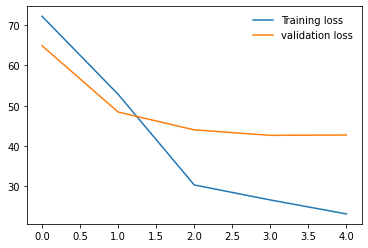

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.86      0.75      0.80         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16



In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  


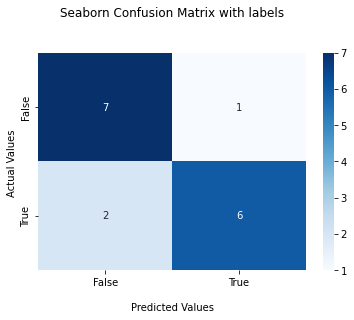

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy1 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy1)
precision = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision)
recall = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall)
score = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score)

Accuracy: 0.812
Precision: 0.817
Recall: 0.812
F-Measure: 0.812


In [ ]:
print(model.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0174, -0.0324,  0.0150,  ..., -0.0161, -0.0138, -0.0227],
        ...,
        [-0.0251,  0.0134, -0.0252,  ...,  0.0219, -0.0157, -0.0256],
        [ 0.0099,  0.0349,  0.0075,  ...,  0.0271, -0.0321, -0.0015],
        [-0.0209,  0.0238, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


#DATA SELECT

### Train and Test split: 
(only 20% data used for testing)
- Total Dataset size: 10392
- Total train size: 8313
- Test train size: 2079

In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_2.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_2.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
বিগত এক বছর ধরে বাংলাদেশ সরকারসহ দেশের সর্বস্তরের মানুষ রোহিঙ্গা শরণার্থীদের পাশে দাঁড়িয়েছে। সেই ধারাবাহিকতায় পিছিয়ে নেই বেসরকাররি প্রতিষ্ঠান ব্র্যাক এবং ব্র্যাক বিশ্ববিদ্যালয়। ব্র্যাক বিশ্ববিদ্যালয়ের জেমস পি গ্রান্ট স্কুল অব পাবলিক হেলথ থেকে পাসকৃত ১৪৮ জন ডিপ্লোমা গ্রাজুয়েট মিডওয়াইফ রোহিঙ্গা শরণার্থী শিবিরে বিভিন্ন সংস্থার হয়ে দক্ষতার সঙ্গে সেবা প্রদান করছেন। ব্র্যাক বিশ্ববিদ্যালয়ের তথ্যমতে গত ছয় মাসে এসকল মিডওয়াইফরা প্রায় ৩ হাজার ২০০টি সাধারণ ডেলিভারি করতে সক্ষম হয়েছেন। মিলিনিয়াম ডেভেলপমেন্ট লক্ষ্য অর্জনে মাতৃমৃত্যু হার এবং শিশু মৃত্যু হার কমিয়ে আনতে কাজ করছে বাংলাদেশ সরকার। বর্তমানে রোহিঙ্গা ক্যাম্পগুলোতেও সরকারের পাশাপাশি বেসরকারি প্রশিক্ষিত মিডওয়াইফরাও কাজ করে যাচ্ছেন নিরলসভাবে। যার ফলে রোহিঙ্গা ক্যাম্পগুলোতেও কাজ করা বিভিন্ন দাতা সংস্থাগুলোতে চাহিদা তৈরি হয়েছে প্রশিক্ষিত মিডওয়াইফদের। জাতীয় জনসংখ্যা গবেষণা ও প্রশিক্ষণ প্রতিষ্ঠান (এনআইপিওআরটি), আন্তর্জাতিক উদরাময় গবেষণা কেন্দ্র বাংলাদেশ (আইসিডিডিআরবি) ও মার্কিন দাতা সংস্থা ইউএসএআইডি ‘বাংলাদেশ মাত

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

# 2nd model

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0294, -0.0284, -0.0186,  ..., -0.0134,  0.0333, -0.0007],
        [-0.0215,  0.0233,  0.0253,  ...,  0.0259, -0.0045, -0.0121],
        [-0.0249, -0.0318, -0.0002,  ..., -0.0280, -0.0027,  0.0171],
        ...,
        [ 0.0123, -0.0065,  0.0218,  ...,  0.0354,  0.0027,  0.0306],
        [ 0.0281, -0.0182,  0.0098,  ..., -0.0073, -0.0218,  0.0204],
        [-0.0227, -0.0131, -0.0231,  ...,  0.0167,  0.0123, -0.0256]])


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.733019.. 	Valid Loss:0.661976.. 	Accuracy: 75.0000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.674386.. 	Valid Loss:0.627179.. 	Accuracy: 75.0000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.433393.. 	Valid Loss:0.618302.. 	Accuracy: 75.0000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.416289.. 	Valid Loss:0.638901.. 	Accuracy: 75.0000
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.387899.. 	Valid Loss:0.638213.. 	Accuracy: 75.0000
Training completed in 19m 22s


In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0174, -0.0324,  0.0150,  ..., -0.0161, -0.0138, -0.0227],
        ...,
        [-0.0251,  0.0134, -0.0252,  ...,  0.0219, -0.0157, -0.0256],
        [ 0.0099,  0.0349,  0.0075,  ...,  0.0271, -0.0321, -0.0015],
        [-0.0209,  0.0238, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.731336.. 	Valid Loss:0.694357.. 	Accuracy: 50.0000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.664254.. 	Valid Loss:0.619742.. 	Accuracy: 68.7500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.408586.. 	Valid Loss:0.639138.. 	Accuracy: 68.7500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.338458.. 	Valid Loss:0.662016.. 	Accuracy: 68.7500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.310236.. 	Valid Loss:0.662682.. 	Accuracy: 68.7500
Training completed in 18m 32s


In [ ]:
training_acc2 = correct / total * 100
training_acc2

68.75

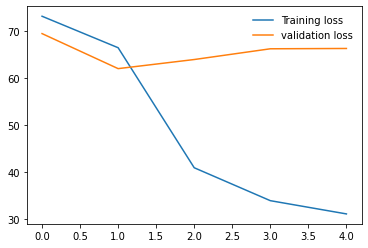

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.64      0.88      0.74         8

    accuracy                           0.69        16
   macro avg       0.72      0.69      0.68        16
weighted avg       0.72      0.69      0.68        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0178,  0.0302,  0.0336,  ..., -0.0023,  0.0108,  0.0291],
        [-0.0319,  0.0298, -0.0072,  ..., -0.0197,  0.0235,  0.0206],
        [-0.0172, -0.0323,  0.0151,  ..., -0.0161, -0.0137, -0.0228],
        ...,
        [-0.0251,  0.0133, -0.0251,  ...,  0.0219, -0.0159, -0.0257],
        [ 0.0100,  0.0349,  0.0075,  ...,  0.0271, -0.0320, -0.0015],
        [-0.0207,  0.0240, -0.0153,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

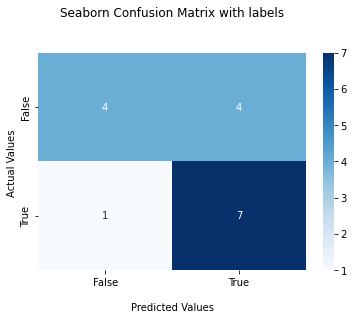

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy2 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy2)
precision2 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision2)
recall2 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall2)
score2 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score2)

Accuracy: 0.688
Precision: 0.718
Recall: 0.688
F-Measure: 0.676


# For Looping

In [ ]:
if precision2 >= precision and recall2 >= recall and score2 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision2
  recall = recall2
  score = score2
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 3rd Model


### Train and Test split: 
(only 20% data used for testing)
- Total Dataset size: 10392
- Total train size: 8313
- Test train size: 2079

In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_3.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_3.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
দেশে আবারও ‘হ্যাপি আওয়ার’ সুবিধা চালু করেছে বিশ্বের প্রথম অন-ডিমান্ড রাইড শেয়ারিং কোম্পানি উবার। এই সুবিধার আওতায় গ্রাহকরা দিনের এবটি নির্দিষ্ট সময়ে ডিসকাউন্ট রেটে সেবা গ্রহণ করতে পারবেন।  সম্প্রতি উবার অ্যাপের নিউজ ফিডে এ তথ্য জানিয়েছে প্রতিষ্ঠানটি। উবার অ্যাপ ব্যবহারকারীরা তাদের মোবাইলেই এ তথ্য দেখতে পারবেন। এক সংবাদ বিজ্ঞপ্তিতে উবার জানিয়েছে, হ্যাপি আওয়ার সুবিধার আওতায় গ্রাহকরা উবার এক্স ও প্রিমিয়ামে ডিসকাউন্ট রেটে সেবা নিতে পারবেন। তবে কত ডিসকাউন্ট দেওয়া হবে সেটা উল্লেখ করা হয়নি। তবে বলা হয়েছে, ডিসকাউন্ট রেট পেতে কোনো প্রোমো কোডের দরকার হবে না। স্বয়ংক্রিয়ভাবে ডিসকাউন্ট রেটেই ভাড়া নির্ধারিত হবে। গ্রাহকরা রবি থেকে বৃহস্পতিবার বেলা ৫টা এবং শুক্র ও শনিবার বেলা ৯টা থেকে ১২ টা পর্যন্ত হ্যাপি আওয়ারের সুবিধা নিতে পারবেন। এছাড়াও ছুটির দিন শুক্র ও শনিবার বেলা ৯টা থেকে দুপুর ১২টা এই সুবিধা উপভোগ করা যাবে।  (ঢাকাটাইমস/৪অক্টোবর/এজেড)

********** After ***************
দেশে আবারও হ্যাপি আওয়ার সুবিধা বিশ্বের অন ডিমান্ড রাইড শেয়ারিং কোম্পানি উবার সুবিধার আওতায় গ্রা

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0174, -0.0324,  0.0150,  ..., -0.0161, -0.0138, -0.0227],
        ...,
        [-0.0251,  0.0134, -0.0252,  ...,  0.0219, -0.0157, -0.0256],
        [ 0.0099,  0.0349,  0.0075,  ...,  0.0271, -0.0321, -0.0015],
        [-0.0209,  0.0238, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.735109.. 	Valid Loss:0.622428.. 	Accuracy: 81.2500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.438700.. 	Valid Loss:0.782036.. 	Accuracy: 62.5000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.250648.. 	Valid Loss:0.667400.. 	Accuracy: 68.7500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.156093.. 	Valid Loss:0.593447.. 	Accuracy: 75.0000
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.130520.. 	Valid Loss:0.594182.. 	Accuracy: 75.0000
Training completed in 20m 15s


In [ ]:
training_acc3 = correct / total * 100
training_acc3

75.0

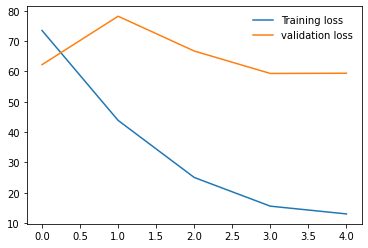

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.70      0.88      0.78         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0174,  0.0304,  0.0334,  ..., -0.0022,  0.0110,  0.0292],
        [-0.0317,  0.0300, -0.0071,  ..., -0.0197,  0.0238,  0.0206],
        [-0.0172, -0.0321,  0.0151,  ..., -0.0163, -0.0135, -0.0231],
        ...,
        [-0.0249,  0.0136, -0.0250,  ...,  0.0217, -0.0156, -0.0260],
        [ 0.0098,  0.0347,  0.0074,  ...,  0.0271, -0.0323, -0.0018],
        [-0.0208,  0.0240, -0.0153,  ...,  0.0213, -0.0038, -0.0178]])


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  


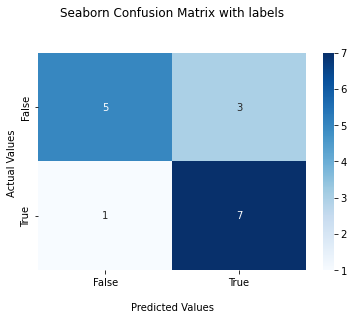

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy3 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy3)
precision3 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision3)
recall3 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall3)
score3 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score3)

Accuracy: 0.750
Precision: 0.767
Recall: 0.750
F-Measure: 0.746


# For Looping

In [ ]:
if precision3 >= precision and recall3 >= recall and score3 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision3
  recall = recall3
  score = score3
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 4th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_4.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_4.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
প্রেমের অভিনয়ে কুষ্টিয়ায় কলেজছাত্রীকে অপহরণ ও গণধর্ষণের দায়ে সাত আসামির যাবজ্জীবন ও একজনের ১৪ বছরের কারাদণ্ডাদেশ ও ৫০ হাজার টাকা জরিমানার আদেশ দিয়েছেন আদালত। বৃহষ্পতিবার বিকালে কুষ্টিয়া নারী ও শিশু নির্যাতন দমন বিশেষ আদালতের বিচারক মুন্সি মো. মশিউর রহমান এ রায় প্রদান করেন।   দণ্ডাদেশপ্রাপ্তরা হল- মো. সাহেব আলী ওরফে শিহাব, জমির সেখ, মসলেম সেখ, আরিফ সেখ, মুক্তার সেখ ওরফে মোকাদ্দেস, ময়েন উদ্দিন ও মিন্টু শেখ। এদের সবার বাড়ি কুষ্টিয়ার কুমারখালী উপজেলার উত্তর সাঁওতা গ্রামে। মামলার অপর আসামি নাজির উদ্দিন সেখে’র ছেলে আরিফ সেখ ওরফে শরীফ আলীকে ১৪ বছরের সশ্রম কারাদণ্ড ও  ৫০ হাজার  টাকা জরিমানার আদেশ দেয় আদালত।   পুলিশ ও আদালত সূত্রে জানা গেছে, কুমারখালীর নাজির উদ্দিন শেখের ছেলে আরিফ শেখ প্রেমের সম্পর্কের অভিনয় করে ২০১১ সালের ৩০ সেপ্টেম্বর কুষ্টিয়া মহিলা কলেজের এক ছাত্রীকে ডেকে নিয়ে বন্ধুর বাড়িতে আটকে রাখে। পরে কুমারখালীর একটি কলা বাগানে ওই কলেজছাত্রীকে রাতভর পালাক্রমে ধর্ষণ করে। পরদিন ১ অক্টোবর গুরুতর আহত অবস্থায় ঐ ছাত্রীকে স্থানীয়রা উদ্ধারের হাসপাতালে ভর্তি করে।

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0174, -0.0324,  0.0150,  ..., -0.0161, -0.0138, -0.0227],
        ...,
        [-0.0251,  0.0134, -0.0252,  ...,  0.0219, -0.0157, -0.0256],
        [ 0.0099,  0.0349,  0.0075,  ...,  0.0271, -0.0321, -0.0015],
        [-0.0209,  0.0238, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.728568.. 	Valid Loss:0.699816.. 	Accuracy: 56.2500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.449491.. 	Valid Loss:0.950161.. 	Accuracy: 50.0000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.294287.. 	Valid Loss:0.763593.. 	Accuracy: 68.7500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.179206.. 	Valid Loss:0.737981.. 	Accuracy: 68.7500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.174497.. 	Valid Loss:0.722208.. 	Accuracy: 68.7500
Training completed in 19m 22s


In [ ]:
training_acc4 = correct / total * 100
training_acc4

68.75

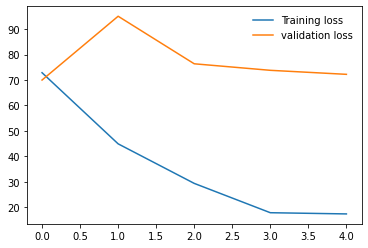

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.53      1.00      0.70         8

    accuracy                           0.56        16
   macro avg       0.77      0.56      0.46        16
weighted avg       0.77      0.56      0.46        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0174,  0.0304,  0.0335,  ..., -0.0023,  0.0110,  0.0292],
        [-0.0317,  0.0300, -0.0071,  ..., -0.0197,  0.0237,  0.0205],
        [-0.0174, -0.0323,  0.0151,  ..., -0.0162, -0.0137, -0.0228],
        ...,
        [-0.0252,  0.0134, -0.0251,  ...,  0.0219, -0.0158, -0.0257],
        [ 0.0100,  0.0350,  0.0075,  ...,  0.0270, -0.0320, -0.0015],
        [-0.0209,  0.0239, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

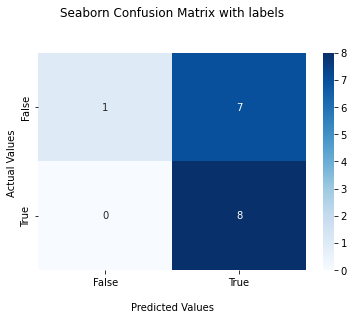

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy4 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy4)
precision4 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision4)
recall4 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall4)
score4 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score4)

Accuracy: 0.562
Precision: 0.767
Recall: 0.562
F-Measure: 0.459


# For Looping

In [ ]:
if precision4 >= precision and recall >= recall3 and score4 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision4
  recall = recall4
  score = score4
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 5th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_5.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_5.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
সাদ্দাম হোসাইন, ব্রাহ্মণবাড়িয়া প্রতিনিধি: ‌‘উন্নয়নের অভিযাত্রায় অদম্য বাংলাদেশ’ এ প্রতিপাদ্যকে সামনে রেখে সারা দেশের ন্যায় ব্রাহ্মণবাড়িয়া জেলার আখাউড়া উপজেলা পরিষদ চত্বরে তিন দিনব্যাপী চতুর্থ জাতীয় উন্নয়ন মেলা বৃহস্পতিবার (৪ অক্টোবর) থেকে শুরু হয়েছে। উন্নয়ন মেলায় ব্রাহ্মণবাড়িয়া পল্লীবিদ্যুৎ সমিতি আখাউড়া জোনাল বোর্ডের পক্ষ থেকে নতুন বিদ্যুৎসংযোগ, বিদ্যুৎ বিল গ্রহণ করা এবং কোন প্রকার অভিযোগ থাকলে সাথে সাথেই তা সমাধানের ব্যাবস্থা সেবা দিচ্ছে তারা। ৪র্থ জাতীয় উন্নয়ন মেলায় সেবা নিতে আসা আখাউড়া পৌরসভার বাসিন্দা মো. আবু হানিফকে, কি সেবা নিতে এসেছেন? জানতে চাইলে বলেন, আমি আমার নতুন মিটারের জন্য আবেদন করতে এসেছি, এমন সেবা দেওয়াতে কর্তৃপক্ষকে ধন্যবাদ জানিয়ে বলেন, সেবা পেতে যাচ্ছি ভালো লাগছে। মালদার পাড়ার আবুল হোসেন বলেন, নতুন বৈদ্যুতিক সংযোগের জন্য অফিসে গেলে ২ থেকে ৩ মাস সময় লাগে কিন্ত ৪র্থ জাতীয় উন্নয়ন মেলায় তা মিলছে সাথে সাথেই, শুনে আমি ও চলে আসলাম সেবা নিতে। আখাউড়া পল্লীবিদ্যুৎ এর ডিজিএম আহাম্মেদ শাহ আল জাবের বলেন, ওয়ান স্টপ সার্ভিসের আওতায় বিদ্যুৎ সংযোগ প্র

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0174, -0.0324,  0.0150,  ..., -0.0161, -0.0138, -0.0227],
        ...,
        [-0.0251,  0.0134, -0.0252,  ...,  0.0219, -0.0157, -0.0256],
        [ 0.0099,  0.0349,  0.0075,  ...,  0.0271, -0.0321, -0.0015],
        [-0.0209,  0.0238, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.771350.. 	Valid Loss:0.703842.. 	Accuracy: 50.0000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.572654.. 	Valid Loss:0.517612.. 	Accuracy: 81.2500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.381000.. 	Valid Loss:0.517836.. 	Accuracy: 75.0000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.294262.. 	Valid Loss:0.522191.. 	Accuracy: 75.0000
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.265643.. 	Valid Loss:0.525143.. 	Accuracy: 75.0000
Training completed in 18m 15s


In [ ]:
training_acc5 = correct / total * 100
training_acc5

75.0

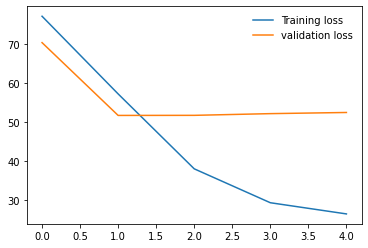

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.73      1.00      0.84         8
           1       1.00      0.62      0.77         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0173, -0.0324,  0.0150,  ..., -0.0162, -0.0139, -0.0227],
        ...,
        [-0.0250,  0.0135, -0.0250,  ...,  0.0218, -0.0156, -0.0258],
        [ 0.0101,  0.0349,  0.0076,  ...,  0.0268, -0.0321, -0.0015],
        [-0.0208,  0.0238, -0.0154,  ...,  0.0212, -0.0041, -0.0176]])


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

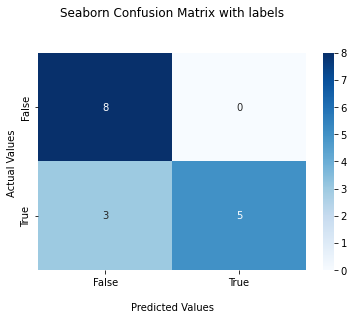

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy5 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy5)
precision5 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision5)
recall5 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall5)
score5 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score5)

Accuracy: 0.812
Precision: 0.864
Recall: 0.812
F-Measure: 0.806


# For Looping

In [ ]:
if precision5 >= precision and recall5 >= recall and score5 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision5
  recall = recall5
  score = score5
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 6th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_6.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_6.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
জেষ্ঠ প্রতিবেদক : নির্বাচন কমিশনে (ইসি) নিবন্ধনের দাবি জানিয়েছে নতুন রাজনৈতিক দল ইনসানিয়াত বিপ্লব বাংলাদেশ। শনিবার বিকেলে ঢাকা রিপোর্টার্স ইউনিটির সাগর রুনি মিলনায়তনে সংবাদ সম্মেলনে এ দাবি জানায় দলটি। দলটির নেতারা অভিযোগ করেন, সব শর্ত পূরণ করা সত্বেও ইসি কোনো কারণ ছাড়াই তাদের নিবন্ধিত করছে না। ইনসানিয়াত বিপ্লবের চেয়ারম্যান আল্লামা ইমাম হায়াত সংবাদ সম্মেলনে মূল বক্তব্য দেন। লিখিত বক্তব্য দেন দলের মহাসচিব শেখ রায়হান রাহবার। এ সময় আরো উপস্থিত ছিলেন- ঢাকা বিশ্ববিদ্যালয়ের অধ্যাপক ড. আতাউর রহমান মিয়াজী, অধ্যাপক ড. এহসানুল হাদী, অ্যাডভোকেট আবু তৌহিদ ভূঁইয়া প্রিন্স প্রমুখ। দলের চেয়ারম্যান আল্লামা ইমাম হায়াত দেশ ও মানবতার স্বার্থে ইনসানিয়াত বিপ্লবের নিবন্ধন দেওয়ার আবেদন জানান। তিনি বলেন, রাজনৈতিক দর্শনে নতুন ধ্যান-ধারণা রুদ্ধ হলে জীবনের গতিশীলতা ও মানবতার বিকাশ রুদ্ধ হয়। জনসমর্থন ও কর্মসূচি থাকা সত্বেও সক্রিয় রাজনৈতিক দলকে নিবন্ধন না দিলে জনগণের সাংবিধানিক ও গণতান্ত্রিক অধিকার ক্ষুণ্ন হয়। নির্বচনের তফসিল ঘোষণার আগে ইনসানিয়াত বিপ্লবের নিবন্ধনের আদেশ চেয়ে হাইকোর্

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0174, -0.0324,  0.0150,  ..., -0.0161, -0.0138, -0.0227],
        ...,
        [-0.0251,  0.0134, -0.0252,  ...,  0.0219, -0.0157, -0.0256],
        [ 0.0099,  0.0349,  0.0075,  ...,  0.0271, -0.0321, -0.0015],
        [-0.0209,  0.0238, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.772496.. 	Valid Loss:0.692711.. 	Accuracy: 50.0000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.721971.. 	Valid Loss:0.659312.. 	Accuracy: 75.0000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.447264.. 	Valid Loss:0.654957.. 	Accuracy: 75.0000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.382859.. 	Valid Loss:0.657928.. 	Accuracy: 75.0000
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.367361.. 	Valid Loss:0.659419.. 	Accuracy: 75.0000
Training completed in 18m 20s


In [ ]:
training_acc6 = correct / total * 100
training_acc6

75.0

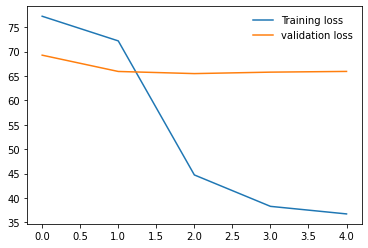

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0300, -0.0071,  ..., -0.0197,  0.0238,  0.0205],
        [-0.0176, -0.0324,  0.0149,  ..., -0.0160, -0.0138, -0.0227],
        ...,
        [-0.0252,  0.0133, -0.0251,  ...,  0.0219, -0.0158, -0.0257],
        [ 0.0100,  0.0350,  0.0075,  ...,  0.0270, -0.0319, -0.0017],
        [-0.0210,  0.0238, -0.0153,  ...,  0.0214, -0.0040, -0.0176]])


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

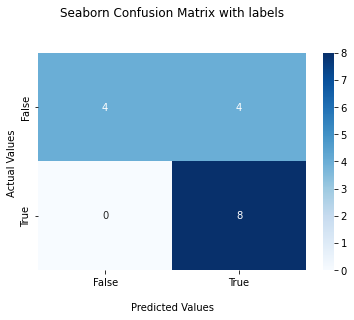

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy6 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy6)
precision6 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision6)
recall6 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall6)
score6 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score6)

Accuracy: 0.750
Precision: 0.833
Recall: 0.750
F-Measure: 0.733


# For Looping

In [ ]:
if precision6 >= precision and recall6 >= recall and score6 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision6
  recall = recall6
  score = score6
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 7th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_7.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_7.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
আনোয়ারায় বিয়ের আসরে খাবার তালিকায় চিংড়ি না পেয়ে তুলকালাম কাণ্ড ঘটানো সেই ‘চিংড়ি বর’ কথা রাখেননি। গত ২৭ সেপ্টেম্বর (বৃহস্পতিবার) বিয়ের প্রীতিভোজে চিংড়ি না দেওয়ায় ভাঙচুর ও আকদ পড়া বউকে না নিয়ে পালিয়ে যায় বর মোহাম্মদ আলমগীর ও তার স্বজনরা। এরপর উদ্ভুত পরিস্থিতি সামাল দিতে গত সোমবার (১ অক্টোবর) সালিশি বৈঠক অনুষ্ঠিত হয়।  বৈঠক বরকে ৩ লাখ টাকা জরিমানা করে এবং সেই টাকা ৪ অক্টোবরের মধ্যে কনের ব্যাংক হিসাব নম্বরে ডিপোজিট করার সিদ্ধান্ত দেয়, যে সিদ্ধান্ত বর-কনের উভয়পক্ষ মেনে নেয়। সালিশী বৈঠকের সিদ্ধান্ত অনুযায়ী গত শুক্রবার নববধূকে ঘরে তুলে নেওয়ার কথা থাকলেও শনিবার পর্যন্ত বর পক্ষ কোনো সিদ্ধান্তই কার্যকর করেনি বলে কনে পক্ষ অভিযোগ তুলেছে। স্থানীয় সূত্রে জানা গেছে, বর পক্ষের কথা না রাখা ও নানামুখি সামাজিক চাপে মানসিক ভাবে ভেঙ্গে পড়েছেন কনের পিতা মোহাম্মদ হোসেন। বিষয়টি নিয়ে তিনি দুশ্চিন্তায় রয়েছেন বলে জানা গেছে। কনের পিতা মোহাম্মদ হোসেন বলেন, ‘এসব আর ভাল লাগছে না। তারা (বর পক্ষ) আমার মেয়ের জীবন নিয়ে তামাশা করছে। ছেলের বাবা জানিয়েছে সালিশি বৈঠকের সেই সব নিরাপত্তা ডিপোজ

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0174, -0.0324,  0.0150,  ..., -0.0161, -0.0138, -0.0227],
        ...,
        [-0.0251,  0.0134, -0.0252,  ...,  0.0219, -0.0157, -0.0256],
        [ 0.0099,  0.0349,  0.0075,  ...,  0.0271, -0.0321, -0.0015],
        [-0.0209,  0.0238, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.731280.. 	Valid Loss:0.628114.. 	Accuracy: 68.7500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.479328.. 	Valid Loss:0.627031.. 	Accuracy: 62.5000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.237605.. 	Valid Loss:0.646541.. 	Accuracy: 62.5000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.202019.. 	Valid Loss:0.656333.. 	Accuracy: 62.5000
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.189751.. 	Valid Loss:0.658668.. 	Accuracy: 62.5000
Training completed in 21m 53s


In [ ]:
training_acc7 = correct / total * 100
training_acc7

62.5

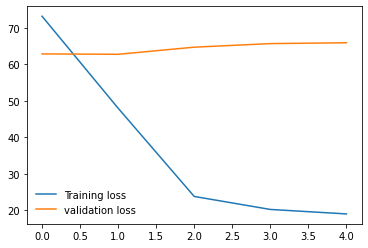

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         8
           1       0.60      0.75      0.67         8

    accuracy                           0.62        16
   macro avg       0.63      0.62      0.62        16
weighted avg       0.63      0.62      0.62        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0298, -0.0073,  ..., -0.0197,  0.0237,  0.0205],
        [-0.0171, -0.0321,  0.0153,  ..., -0.0162, -0.0136, -0.0229],
        ...,
        [-0.0248,  0.0137, -0.0249,  ...,  0.0218, -0.0156, -0.0258],
        [ 0.0102,  0.0349,  0.0078,  ...,  0.0270, -0.0321, -0.0017],
        [-0.0207,  0.0240, -0.0152,  ...,  0.0213, -0.0038, -0.0177]])


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

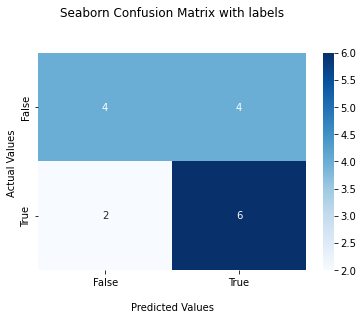

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy7 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy7)
precision7 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision7)
recall7 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall7)
score7 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score7)

Accuracy: 0.625
Precision: 0.633
Recall: 0.625
F-Measure: 0.619


# For Looping

In [ ]:
if precision7 >= precision and recall7 >= recall and score7 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision7
  recall = recall7
  score = score7
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 8th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_8.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_8.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
নিজস্ব প্রতিবেদক, গাজীপুর : গাজীপুরের গজারি বন থেকে ১২ হাজার লিটার চোলাই মদসহ দুই ব্যক্তিকে গ্রেপ্তার করেছে র‌্যাব-১-এর সদস্যরা। রোববার দুপুরে গাজীপুর সিটি করর্পোরেশনের কুমারখাদা এলাকায় অভিযান পরিচালিত হয়। পরে গ্রেপ্তারকৃতদের ভ্রাম্যমাণ আদালতে হাজির করলে আদালতের বিচারক তাদের কারাদণ্ড দেন। দণ্ডপ্রাপ্তরা হলেন- কুমারখাদা এলাকার মৃত অমূল্য চন্দ্র বর্মনের ছেলে অনন্ত বর্মন (২৫) এবং তার সহযোগী একই এলাকার মো. বারেক হোসেনের ছেলে কামাল হোসেন (২৪)। র‌্যাব জানায়, কুমারখাদা গজারি বনের ভিতরে চোলাই মদ উৎপাদনসহ ক্রয়-বিক্রয় হচ্ছে-এমন গোপন সংবাদের ভিত্তিতে দুপুর আড়াইটার দিকে র‌্যাব-১ এর গাজীপুরের পোড়াবাড়ী ক্যাম্পের কোম্পানি কমান্ডার আব্দুল্লাহ আল মামুন ও নির্বাহী ম্যাজিস্ট্রেট রুবাইয়া ইয়াসমিনের নেতৃত্বে অভিযান পরিচালনা করা হয়। এ সময় ১২ হাজার লিটার চোলাই মদ এবং মদ তৈরির উপকরণসহ দুই ব্যক্তিকে হাতেনাতে গ্রেপ্তার করা হয়। পরে ভ্রাম্যমাণ আদালতের বিচারক গ্রেপ্তার অনন্ত বর্মনকে ছয় মাসের বিনাশ্রম কারাদণ্ড এবং কামাল হোসেনকে তিন মাসের বিনাশ্রম কারাদণ্ড দেন। নির্বাহী ম্যাজিস্ট্রেট

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0174, -0.0324,  0.0150,  ..., -0.0161, -0.0138, -0.0227],
        ...,
        [-0.0251,  0.0134, -0.0252,  ...,  0.0219, -0.0157, -0.0256],
        [ 0.0099,  0.0349,  0.0075,  ...,  0.0271, -0.0321, -0.0015],
        [-0.0209,  0.0238, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.747205.. 	Valid Loss:0.652310.. 	Accuracy: 81.2500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.638983.. 	Valid Loss:0.575715.. 	Accuracy: 68.7500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.455269.. 	Valid Loss:0.547379.. 	Accuracy: 75.0000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.410951.. 	Valid Loss:0.523784.. 	Accuracy: 81.2500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.386962.. 	Valid Loss:0.521802.. 	Accuracy: 81.2500
Training completed in 21m 4s


In [ ]:
training_acc8 = correct / total * 100
training_acc8

81.25

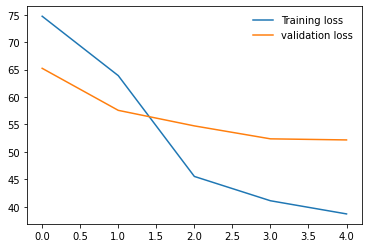

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0176,  0.0304,  0.0334,  ..., -0.0020,  0.0108,  0.0292],
        [-0.0319,  0.0297, -0.0073,  ..., -0.0195,  0.0235,  0.0207],
        [-0.0172, -0.0322,  0.0151,  ..., -0.0162, -0.0136, -0.0228],
        ...,
        [-0.0250,  0.0136, -0.0252,  ...,  0.0219, -0.0155, -0.0256],
        [ 0.0101,  0.0349,  0.0077,  ...,  0.0269, -0.0319, -0.0017],
        [-0.0207,  0.0241, -0.0154,  ...,  0.0213, -0.0035, -0.0176]])


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

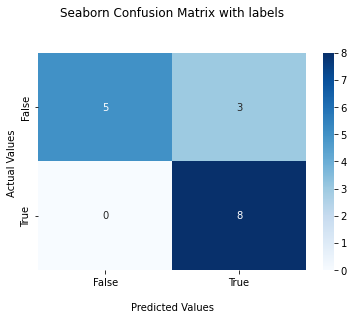

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy8 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy8)
precision8 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision8)
recall8 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall8)
score8 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score8)

Accuracy: 0.812
Precision: 0.864
Recall: 0.812
F-Measure: 0.806


# For Looping

In [ ]:
if precision8 >= precision and recall8 >= recall and score8 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision8
  recall = recall8
  score = score8
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 9th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_9.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_9.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
সংযুক্ত আরব আমিরাতে এসো গড়ি মাতৃভূমি- ‘কাম অ্যান্ড বিল্ড ইয়োর মাদারল্যান্ড’ শিরোনামে (এনআরবি) সেন্টার ফর নন-রেসিডেন্ট বাংলাদেশের দুবাই কনফারেন্স অনুষ্ঠিত হয়েছে। শুক্রবার আমিরাতের বাণিজ্যিক শহর দুবাইয়ের একটি অভিজাত রেস্তোরাঁয় আয়োজিত অনুষ্ঠানে সভাপতিত্ব করেন এনআরবি চেয়ারম্যান সেকিল চৌধুরী। বক্তব্য রাখেন বাংলাদেশ জাতীয় পরিচয়পত্রের ডিজি ব্রিগেডিয়ার জেনারেল সাইদুল ইসলাম, রিয়েল এস্টেট অ্যান্ড হাউজিং অ্যাসোসিয়েশন অব বাংলাদেশের (রিহাব) ভাইস প্রেসিডেন্ট লিয়াকত আলী ভূঁইয়া, বাংলাদেশ এম্বাসি আবুধাবির মিনিস্টার ইকবাল হোসেন খান, জাতীয় রাজস্ব বোর্ডের (এনবিআর) চেয়ারম্যান মোশারফ হোসেন ভূঁইয়া ও বাংলাদেশ সমিতি আবুধাবির প্রেসিডেন্ট ইঞ্জি. মোয়াজ্জেম হোসেন। এ সময় আরও বক্তব্য রাখেন আমিরাত প্রবাসী ইঞ্জি. আবু জাফর, জহিরুল ইসলাম, মাহবুব আলম মানিক, মধ্যপ্রাচ্যের প্রথম মহিলা সিআইপি জেসমিন আক্তার, এনআরবি চেয়ারম্যানের সহধর্মিণী জহুরা চৌধুরী, মাওলানা ফজলুল কবির, ইঞ্জি. নওশের আলী, বাংলাদেশ সমিতি শারজাহ শাখার সভাপতি আবুল বাশার, ইঞ্জি. আবু হেনা, ইঞ্জি. আব্দুল বাতেন, ইঞ্জি. মহিউদ্দিন 

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[-0.0175,  0.0303,  0.0335,  ..., -0.0022,  0.0109,  0.0291],
        [-0.0317,  0.0299, -0.0072,  ..., -0.0197,  0.0237,  0.0206],
        [-0.0174, -0.0324,  0.0150,  ..., -0.0161, -0.0138, -0.0227],
        ...,
        [-0.0251,  0.0134, -0.0252,  ...,  0.0219, -0.0157, -0.0256],
        [ 0.0099,  0.0349,  0.0075,  ...,  0.0271, -0.0321, -0.0015],
        [-0.0209,  0.0238, -0.0154,  ...,  0.0213, -0.0039, -0.0176]])


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

In [ ]:
training_acc9 = correct / total * 100
training_acc9

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

In [ ]:
print(model2.fc1.weight.data)

In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy9 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy9)
precision9 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision9)
recall9 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall9)
score9 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score9)

# For Looping

In [ ]:
if precision9 >= precision and recall9 >= recall and score9 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision9
  recall = recall9
  score = score9
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 10th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_10.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_10.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

In [ ]:
training_acc10 = correct / total * 100
training_acc10

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

In [ ]:
print(model2.fc1.weight.data)

In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy10 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy10)
precision10 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision10)
recall10 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall10)
score10 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score10)

# For Looping

In [ ]:
if precision10 >= precision and recall10 >= recall and score10 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision10
  recall = recall10
  score = score10
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 11th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_11.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_11.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

In [ ]:
training_acc11 = correct / total * 100
training_acc11

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

In [ ]:
print(model2.fc1.weight.data)

In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy11 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy11)
precision11 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision11)
recall11 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall11)
score11 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score11)

# For Looping

In [ ]:
if precision11 >= precision and recall11 >= recall and score11 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision11
  recall = recall11
  score = score11
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 12th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_12.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_12.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

In [ ]:
training_acc12 = correct / total * 100
training_acc12

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

In [ ]:
print(model2.fc1.weight.data)

In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy12 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy12)
precision12 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision12)
recall12 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall12)
score12 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score12)

# For Looping

In [ ]:
if precision12 >= precision and recall12 >= recall and score12 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision12
  recall = recall12
  score = score12
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 13th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/auth_set_13.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /40%/fake_set_13.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

In [ ]:
training_acc13 = correct / total * 100
training_acc13

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

In [ ]:
print(model2.fc1.weight.data)

In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy13 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy13)
precision13 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision13)
recall13 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall13)
score13 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score13)

# For Looping

In [ ]:
if precision13 >= precision and recall13 >= recall and score13 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision13
  recall = recall13
  score = score13
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()